In [1]:
# Importaciones
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))  # Nombre de tu GPU

True
1
NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
print(dir(torch))  # Debe incluir '_utils' en la lista

['AVG', 'AggregationType', 'AliasDb', 'AnyType', 'Argument', 'ArgumentSpec', 'AwaitType', 'BFloat16Storage', 'BFloat16Tensor', 'BenchmarkConfig', 'BenchmarkExecutionStats', 'Block', 'BoolStorage', 'BoolTensor', 'BoolType', 'BufferDict', 'ByteStorage', 'ByteTensor', 'CallStack', 'Capsule', 'CharStorage', 'CharTensor', 'ClassType', 'Code', 'CompilationUnit', 'CompleteArgumentSpec', 'ComplexDoubleStorage', 'ComplexFloatStorage', 'ComplexType', 'ConcreteModuleType', 'ConcreteModuleTypeBuilder', 'DeepCopyMemoTable', 'DeserializationStorageContext', 'DeviceObjType', 'DictType', 'DisableTorchFunction', 'DisableTorchFunctionSubclass', 'DispatchKey', 'DispatchKeySet', 'DoubleStorage', 'DoubleTensor', 'EnumType', 'ErrorReport', 'Event', 'ExcludeDispatchKeyGuard', 'ExecutionPlan', 'FatalError', 'FileCheck', 'FloatStorage', 'FloatTensor', 'FloatType', 'FunctionSchema', 'Future', 'FutureType', 'Generator', 'GradScaler', 'Gradient', 'Graph', 'GraphExecutorState', 'HalfStorage', 'HalfTensor', 'IODesc

In [4]:
torch.cuda.empty_cache() 

In [5]:
import torch.nn as nn

# ReLU -> ReLU(x)=max(0,x) devuelve el valor x si es mayor que 0, de lo contrario devuelve 0
# BatchNorm -> Normaliza la salida de la capa anterior, manteniendo la media y varianza

class FruitMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), # Aplana la imagen de entrada

            # capa de entrada -> primera capa oculta
            nn.Linear(100*100*3, 512),  # Capa amplia para fondos variables
            nn.BatchNorm1d(512), # Normalización para estabilizar la red, a una dimension
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout para evitar sobreajuste
            
            # primera capa oculta -> segunda capa oculta
            nn.Linear(512, 128), # Refinamiento de características
            nn.BatchNorm1d(128), # Normalización para estabilizar la red, a una dimension
            nn.ReLU(),
            
            # segunda capa oculta -> capa de salida
            nn.Linear(128, 169) # Salida (169 frutas)
        )
    
    def forward(self, x):
        # x es la imagen de entrada
        return self.layers(x)

In [6]:
# 2. Instanciar el modelo
model = FruitMLP()
print("Modelo creado!")

Modelo creado!


In [7]:
# 3. Verificar GPU y mover el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")

# limpiar_memoria()  # Libera memoria de la GPU antes de mover el modelo
model = model.to(device)  # Mueve el modelo a GPU/CPU
print("¡Modelo enviado a", device, "!")

Dispositivo seleccionado: cuda
¡Modelo enviado a cuda !


In [8]:
# Transformación TEMPORAL para cálculo (sin normalización)
temp_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
# Cargar el conjunto de datos de entrenamiento en la GPU
train_dataset_temp = datasets.ImageFolder(
    root='C:/Users/OMEN/Documents/7mo Semestre-01-2025/Inteligencia Artificial/Lab-002/fruits-360/Training',
    transform=temp_transform
)

train_loader_temp = torch.utils.data.DataLoader( # dataLolder -> es un objeto iterable
    train_dataset_temp,
    batch_size=64,  # Tamaño del lote
    shuffle=False,   # Barajar los datos en False
)
# Cálculo de la media y desviación estándar
mean = torch.zeros(3).to(device)  # Inicializa el tensor de media
std = torch.zeros(3).to(device)   # Inicializa el tensor de desviación estándar
total_pixels = 0  # Inicializa el contador de píxeles

# Iterar sobre el conjunto de datos de entrenamiento
# para calcular la media y desviación estándar
# (sin normalización)
for images, _ in train_loader_temp:
    images = images.to(device)  # Manda batch a GPU
    batch_pixels = images.size(0) * images.size(2) * images.size(3)  # batch * altura * ancho
    images = images.view(images.size(0), 3, -1)  # [batch, canales, pixels]
    
    mean += images.mean(2).sum(0)  # Suma medias por canal
    std += images.std(2).sum(0)    # Suma std por canal
    total_pixels += batch_pixels

mean /= len(train_loader_temp.dataset)
std /= len(train_loader_temp.dataset)

print("Media (Train):", mean.cpu().tolist()) # media 
print("Std (Train):", std.cpu().tolist()) # desviación estándar / standard deviation

Media (Train): [0.6726435422897339, 0.5792443752288818, 0.508468508720398]
Std (Train): [0.26989850401878357, 0.32609033584594727, 0.3682645261287689]


In [15]:
indice = 4000  # Cambia este número al que desees

# Obtener la imagen específica
imagen, etiqueta = train_dataset_temp[indice]
print(f"clase:{train_dataset_temp.classes[etiqueta]}")

# Imprimir el tensor
print(f"Tensor de la imagen en el índice {indice}:")
print(imagen)

clase:Apple 6
Tensor de la imagen en el índice 4000:
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
     

In [17]:
imagen , etiqueta= train_dataset_temp[300]
print(f"clase:{train_dataset_temp.classes[etiqueta]}")
print(imagen)

clase:Apple 10
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0

In [24]:
# valores calculados
#Media = [0.6726, 0.5792, 0.5084]
#Std = [0.2698, 0.3260, 0.3683]

Media = [0.6726435422897339, 0.5792443752288818, 0.508468508720398]
Std = [0.26989850401878357, 0.32609033584594727, 0.3682645261287689]

# Normalización de los datos
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=Media, std=Std)  # Normalización crítica
])

# Transformación para el conjunto de test
test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Media, std=Std)  # Normalización crítica
])

# Cargar el conjunto de datos de entrenamiento y Test
train_dataset = datasets.ImageFolder( # el ImageFolder es un objeto iterable
    # Cargar el conjunto de datos de entrenamiento
    root= "C:/Users/OMEN/Documents/7mo Semestre-01-2025/Inteligencia Artificial/Lab-002/fruits-360/Training",
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root="C:/Users/OMEN/Documents/7mo Semestre-01-2025/Inteligencia Artificial/Lab-002/fruits-360/Test",
    transform=test_transform
)

# Creamos DataLoader para cargar los datos / que es el dataLoader -> 
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,          # Batch grande para estabilidad
    shuffle=True,            # Mezcla para entrenamiento
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,           # No mezclar en test
)

# Verificación
print(f"Clases: {len(train_dataset.classes)}")  # Debe mostrar 169
print(f"Imágenes en entrenamiento: {len(train_dataset)}")
print(f"Imágenes en test: {len(test_dataset)}")

print(f"Clases: {train_dataset.classes}")  # Debe mostrar 169
print("indice de clases:", train_dataset.class_to_idx)  # Muestra el índice de clases

print(f"clases de test: {test_dataset.classes}")  # Debe mostrar 170
print("indice de clases:", test_dataset.class_to_idx)  # Muestra el índice de clases

Clases: 169
Imágenes en entrenamiento: 86308
Imágenes en test: 28863
Clases: ['Apple 10', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 19', 'Apple 6', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wa

El DataLoader en PyTorch es una utilidad fundamental que se encarga de cargar, organizar y procesar tus datos de manera eficiente durante el entrenamiento de tu red neuronal.

Etiqueta: Pistachio 1


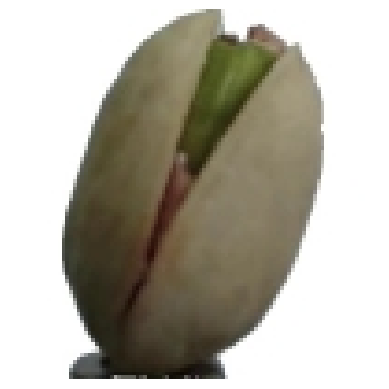

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convertir a HWC
    img = img * std.cpu().numpy() + mean.cpu().numpy()  # Desnormalizar
    img = np.clip(img, 0, 1)                     # Asegurar rango [0,1]
    plt.imshow(img)
    plt.axis('off')

# Mostrar primera imagen del batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0])
print(f"Etiqueta: {train_dataset.classes[labels[0]]}")

Etiqueta: Pear 2


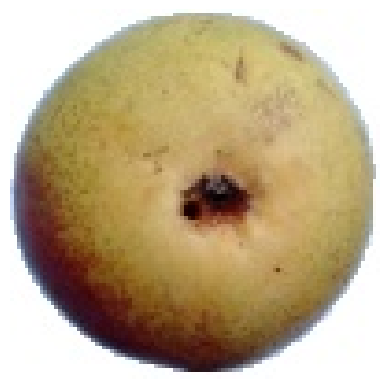

In [26]:
# Mostrar primera imagen del batch
dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(images[0])
print(f"Etiqueta: {train_dataset.classes[labels[0]]}")

In [42]:
for images, labels in test_loader:
    print("labels en entrenamiento", labels)
    break

labels en entrenamiento tensor([129, 122,  25, 106, 102, 127, 159, 132,  30, 122,  77,  85,  37,  79,
         68, 125,   1, 109,  61,  85,   5, 124, 168, 110, 127,  71,  31, 145,
         48,  46, 127,  55])


1. Optimizador: SGD (Descenso de Gradiente Estocástico)
Explicación breve para el curso:
El SGD (Stochastic Gradient Descent) es uno de los optimizadores más básicos en Deep Learning. Su función es ajustar los pesos de la red neuronal mediante el cálculo del gradiente (derivada) de la función de pérdida.

Ventajas:

Simple y fácil de entender.

Funciona bien en muchos problemas clásicos.

Permfine ajustar manualmente la tasa de aprendizaje (learning rate).

Hiperparámetros clave:

lr (Learning Rate): Controla el tamaño de los pasos en la actualización de los pesos (demasiado alto → inestabilidad; demasiado bajo → lento).

momentum (opcional): Ayuda a evitar mínimos locales y acelera la convergencia.

2. Función de Pérdida (Loss Function)
La más básica y necesaria: CrossEntropyLoss

¿Qué hace?

Mide qué tan lejos están las predicciones de la red (logits) de las etiquetas reales.

Combina LogSoftmax + NLLLoss (Negative Log Likelihood Loss) en una sola función.

Ideal para problemas de clasificación multiclase (como tu caso con 170 clases).



In [ ]:
# Optimizador (SGD)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95, weight_decay=1e-5) 
#optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# el weight decay es la regularización L2 osea la penalización de los pesos
# SGD -> Stochastic Gradient Descent (descenso de gradiente estocástico)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
# Scheduler para reducir la tasa de aprendizaje si el rendimiento no mejora
# (patience=2 significa esperar 2 épocas antes de reducir la tasa de aprendizaje)
# Scheduler para reducir la tasa de aprendizaje
# (scheduler) -> ReduceLROnPlateau reduce la tasa de aprendizaje si la métrica no mejora
# (mode='min') -> se usa para problemas de regresión 
# (patience=2) -> número de épocas sin mejora antes de reducir la tasa

print("¡Optimizador y función de pérdida creados!")
print("optimizador", optimizer)
print("función de pérdida", criterion)
#print("Scheduler", scheduler)

¡Optimizador y función de pérdida creados!
optimizador SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)
función de pérdida CrossEntropyLoss()


# funcion dde entrenamiento

In [44]:
def entrenar_epoca(modelo, cargador, optimizador, criterio, dispositivo):
    modelo.train()
    perdida_total = 0.0
    correctas = 0
    total = 0
    
    with tqdm(cargador, unit="batch", desc="Entrenamiento") as barra:
        for imagenes, etiquetas in barra:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            
            optimizador.zero_grad()
            salidas = modelo(imagenes)
            perdida = criterio(salidas, etiquetas)
            perdida.backward()
            optimizador.step()
            
            perdida_total += perdida.item()
            _, predichas = torch.max(salidas, 1)
            correctas += (predichas == etiquetas).sum().item()
            total += etiquetas.size(0)
            
            barra.set_postfix(
                perdida=perdida.item(),
                precision=f"{100 * correctas / total:.2f}%"
            )
    
    # calcular el porcentaje de error
    error = 100 * (1 - correctas / total)
    return perdida_total / len(cargador), 100 * correctas / total, error

# funcion de validacion

In [46]:
def evaluar(modelo, cargador, criterio, dispositivo):
    modelo.eval()  # Modo evaluación
    perdida_total = 0.0
    correctas = 0
    total = 0

    with torch.no_grad():  # Desactiva gradientes
        for imagenes, etiquetas in tqdm(cargador, desc="Prueba"):
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = modelo(imagenes)
            perdida = criterio(salidas, etiquetas)
            
            # Métricas
            perdida_total += perdida.item()
            _, predichas = torch.max(salidas, 1)
            correctas += (predichas == etiquetas).sum().item()
            total += etiquetas.size(0)

    error_porcentaje = (1 - correctas / total) * 100
    
    return perdida_total / len(cargador), 100 * correctas / total, error_porcentaje

In [47]:
def graficar_resultados(perdidas_ent, precision_ent, perdidas_test, precision_test):
    plt.figure(figsize=(12, 5))
    
    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(perdidas_ent, label='Entrenamiento')
    plt.plot(perdidas_test, label='Prueba')
    plt.title('Pérdida por Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Gráfica de precisión
    plt.subplot(1, 2, 2)
    plt.plot(precision_ent, label='Entrenamiento')
    plt.plot(precision_test, label='Prueba')
    plt.title('Precisión por Época')
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# --- 5. Bucle de Entrenamiento ---

VRAM usada: 58.94 MB

Época 1/50


Prueba: 100%|██████████| 902/902 [02:56<00:00,  5.11it/s]



Resumen Época 1:
  Pérdida: Train = 4.2702 | Test = 3.8742
  Precisión: Train = 30.35% | Test = 53.01%
  Error: entrenamiento: 69.6540% | error test: 46.9944%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 2/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.33it/s]



Resumen Época 2:
  Pérdida: Train = 3.5732 | Test = 3.4273
  Precisión: Train = 55.31% | Test = 61.27%
  Error: entrenamiento: 44.6923% | error test: 38.7278%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 3/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.81it/s]



Resumen Época 3:
  Pérdida: Train = 3.0627 | Test = 2.9363
  Precisión: Train = 64.74% | Test = 65.36%
  Error: entrenamiento: 35.2609% | error test: 34.6395%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 4/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.27it/s]



Resumen Época 4:
  Pérdida: Train = 2.6031 | Test = 2.5003
  Precisión: Train = 71.10% | Test = 69.87%
  Error: entrenamiento: 28.8988% | error test: 30.1285%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 5/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.31it/s]



Resumen Época 5:
  Pérdida: Train = 2.1900 | Test = 2.1535
  Precisión: Train = 76.80% | Test = 74.47%
  Error: entrenamiento: 23.2018% | error test: 25.5344%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 6/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.54it/s]



Resumen Época 6:
  Pérdida: Train = 1.8295 | Test = 1.8855
  Precisión: Train = 81.97% | Test = 77.47%
  Error: entrenamiento: 18.0342% | error test: 22.5271%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 7/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.22it/s]



Resumen Época 7:
  Pérdida: Train = 1.5209 | Test = 1.6252
  Precisión: Train = 86.20% | Test = 80.34%
  Error: entrenamiento: 13.8041% | error test: 19.6584%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 8/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.68it/s]



Resumen Época 8:
  Pérdida: Train = 1.2704 | Test = 1.4344
  Precisión: Train = 89.23% | Test = 82.37%
  Error: entrenamiento: 10.7684% | error test: 17.6281%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 9/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.36it/s]



Resumen Época 9:
  Pérdida: Train = 1.0588 | Test = 1.2299
  Precisión: Train = 91.70% | Test = 83.61%
  Error: entrenamiento: 8.3040% | error test: 16.3947%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 10/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.75it/s]



Resumen Época 10:
  Pérdida: Train = 0.8893 | Test = 1.1160
  Precisión: Train = 93.43% | Test = 84.41%
  Error: entrenamiento: 6.5718% | error test: 15.5909%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 11/50


Prueba: 100%|██████████| 902/902 [00:22<00:00, 40.31it/s]



Resumen Época 11:
  Pérdida: Train = 0.7494 | Test = 0.9999
  Precisión: Train = 94.60% | Test = 85.75%
  Error: entrenamiento: 5.3981% | error test: 14.2501%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 12/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.63it/s]



Resumen Época 12:
  Pérdida: Train = 0.6427 | Test = 0.9381
  Precisión: Train = 95.59% | Test = 86.28%
  Error: entrenamiento: 4.4109% | error test: 13.7235%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 13/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.23it/s]



Resumen Época 13:
  Pérdida: Train = 0.5506 | Test = 0.8286
  Precisión: Train = 96.41% | Test = 87.22%
  Error: entrenamiento: 3.5883% | error test: 12.7811%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 14/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.61it/s]



Resumen Época 14:
  Pérdida: Train = 0.4836 | Test = 0.7833
  Precisión: Train = 96.94% | Test = 87.21%
  Error: entrenamiento: 3.0577% | error test: 12.7880%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 15/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.60it/s]



Resumen Época 15:
  Pérdida: Train = 0.4254 | Test = 0.7195
  Precisión: Train = 97.49% | Test = 87.60%
  Error: entrenamiento: 2.5061% | error test: 12.4000%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 16/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.62it/s]



Resumen Época 16:
  Pérdida: Train = 0.3740 | Test = 0.7052
  Precisión: Train = 97.85% | Test = 87.77%
  Error: entrenamiento: 2.1493% | error test: 12.2267%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 17/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.80it/s]



Resumen Época 17:
  Pérdida: Train = 0.3356 | Test = 0.6622
  Precisión: Train = 98.16% | Test = 88.12%
  Error: entrenamiento: 1.8388% | error test: 11.8837%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 18/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.36it/s]



Resumen Época 18:
  Pérdida: Train = 0.3044 | Test = 0.6340
  Precisión: Train = 98.34% | Test = 88.64%
  Error: entrenamiento: 1.6569% | error test: 11.3640%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 19/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.82it/s]



Resumen Época 19:
  Pérdida: Train = 0.2720 | Test = 0.6144
  Precisión: Train = 98.62% | Test = 88.90%
  Error: entrenamiento: 1.3846% | error test: 11.1007%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 20/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.74it/s]



Resumen Época 20:
  Pérdida: Train = 0.2477 | Test = 0.5873
  Precisión: Train = 98.80% | Test = 89.49%
  Error: entrenamiento: 1.1992% | error test: 10.5083%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 21/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.49it/s]



Resumen Época 21:
  Pérdida: Train = 0.2294 | Test = 0.5691
  Precisión: Train = 98.98% | Test = 89.55%
  Error: entrenamiento: 1.0196% | error test: 10.4494%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 22/50


Prueba: 100%|██████████| 902/902 [00:21<00:00, 42.80it/s]



Resumen Época 22:
  Pérdida: Train = 0.2110 | Test = 0.5645
  Precisión: Train = 99.06% | Test = 89.64%
  Error: entrenamiento: 0.9373% | error test: 10.3593%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 23/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.12it/s]



Resumen Época 23:
  Pérdida: Train = 0.1898 | Test = 0.5472
  Precisión: Train = 99.26% | Test = 89.51%
  Error: entrenamiento: 0.7415% | error test: 10.4875%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 24/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.86it/s]



Resumen Época 24:
  Pérdida: Train = 0.1786 | Test = 0.5249
  Precisión: Train = 99.25% | Test = 89.86%
  Error: entrenamiento: 0.7543% | error test: 10.1445%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 25/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.41it/s]



Resumen Época 25:
  Pérdida: Train = 0.1657 | Test = 0.5222
  Precisión: Train = 99.37% | Test = 89.86%
  Error: entrenamiento: 0.6315% | error test: 10.1445%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 26/50


Prueba: 100%|██████████| 902/902 [00:21<00:00, 42.80it/s]



Resumen Época 26:
  Pérdida: Train = 0.1555 | Test = 0.5041
  Precisión: Train = 99.39% | Test = 90.00%
  Error: entrenamiento: 0.6118% | error test: 9.9955%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 27/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.61it/s]



Resumen Época 27:
  Pérdida: Train = 0.1442 | Test = 0.4970
  Precisión: Train = 99.48% | Test = 90.15%
  Error: entrenamiento: 0.5179% | error test: 9.8534%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 28/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 42.99it/s]



Resumen Época 28:
  Pérdida: Train = 0.1345 | Test = 0.4827
  Precisión: Train = 99.55% | Test = 90.57%
  Error: entrenamiento: 0.4461% | error test: 9.4273%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 29/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.69it/s]



Resumen Época 29:
  Pérdida: Train = 0.1286 | Test = 0.4775
  Precisión: Train = 99.59% | Test = 90.07%
  Error: entrenamiento: 0.4102% | error test: 9.9297%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 30/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.79it/s]



Resumen Época 30:
  Pérdida: Train = 0.1241 | Test = 0.4720
  Precisión: Train = 99.56% | Test = 90.24%
  Error: entrenamiento: 0.4414% | error test: 9.7634%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 31/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 44.04it/s]



Resumen Época 31:
  Pérdida: Train = 0.1175 | Test = 0.4624
  Precisión: Train = 99.56% | Test = 90.65%
  Error: entrenamiento: 0.4391% | error test: 9.3476%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 32/50


Prueba: 100%|██████████| 902/902 [00:22<00:00, 40.17it/s]



Resumen Época 32:
  Pérdida: Train = 0.1107 | Test = 0.4628
  Precisión: Train = 99.64% | Test = 90.60%
  Error: entrenamiento: 0.3569% | error test: 9.4030%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 33/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.49it/s]



Resumen Época 33:
  Pérdida: Train = 0.1096 | Test = 0.4505
  Precisión: Train = 99.58% | Test = 90.70%
  Error: entrenamiento: 0.4160% | error test: 9.2956%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 34/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.46it/s]



Resumen Época 34:
  Pérdida: Train = 0.0988 | Test = 0.4498
  Precisión: Train = 99.69% | Test = 90.29%
  Error: entrenamiento: 0.3059% | error test: 9.7149%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 35/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.71it/s]



Resumen Época 35:
  Pérdida: Train = 0.0954 | Test = 0.4500
  Precisión: Train = 99.69% | Test = 90.80%
  Error: entrenamiento: 0.3094% | error test: 9.2021%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 36/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.48it/s]



Resumen Época 36:
  Pérdida: Train = 0.0900 | Test = 0.4389
  Precisión: Train = 99.73% | Test = 90.78%
  Error: entrenamiento: 0.2734% | error test: 9.2194%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 37/50


Prueba: 100%|██████████| 902/902 [00:22<00:00, 39.29it/s]



Resumen Época 37:
  Pérdida: Train = 0.0880 | Test = 0.4322
  Precisión: Train = 99.74% | Test = 90.94%
  Error: entrenamiento: 0.2642% | error test: 9.0635%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 38/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.74it/s]



Resumen Época 38:
  Pérdida: Train = 0.0834 | Test = 0.4238
  Precisión: Train = 99.73% | Test = 90.92%
  Error: entrenamiento: 0.2700% | error test: 9.0843%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 39/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.37it/s]



Resumen Época 39:
  Pérdida: Train = 0.0827 | Test = 0.4187
  Precisión: Train = 99.74% | Test = 91.20%
  Error: entrenamiento: 0.2595% | error test: 8.7967%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 40/50


Prueba: 100%|██████████| 902/902 [00:20<00:00, 43.83it/s]



Resumen Época 40:
  Pérdida: Train = 0.0756 | Test = 0.4194
  Precisión: Train = 99.78% | Test = 90.85%
  Error: entrenamiento: 0.2225% | error test: 9.1501%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 41/50


Prueba: 100%|██████████| 902/902 [00:21<00:00, 42.95it/s]



Resumen Época 41:
  Pérdida: Train = 0.0780 | Test = 0.4190
  Precisión: Train = 99.77% | Test = 90.99%
  Error: entrenamiento: 0.2283% | error test: 9.0081%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 42/50


Prueba: 100%|██████████| 902/902 [00:35<00:00, 25.39it/s]



Resumen Época 42:
  Pérdida: Train = 0.0702 | Test = 0.4123
  Precisión: Train = 99.78% | Test = 91.23%
  Error: entrenamiento: 0.2155% | error test: 8.7725%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 43/50


Prueba: 100%|██████████| 902/902 [00:36<00:00, 24.98it/s]



Resumen Época 43:
  Pérdida: Train = 0.0674 | Test = 0.4136
  Precisión: Train = 99.84% | Test = 90.83%
  Error: entrenamiento: 0.1611% | error test: 9.1674%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 44/50


Prueba: 100%|██████████| 902/902 [00:34<00:00, 25.80it/s]



Resumen Época 44:
  Pérdida: Train = 0.0644 | Test = 0.4124
  Precisión: Train = 99.81% | Test = 90.94%
  Error: entrenamiento: 0.1923% | error test: 9.0566%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 45/50


Prueba: 100%|██████████| 902/902 [00:46<00:00, 19.54it/s]



Resumen Época 45:
  Pérdida: Train = 0.0617 | Test = 0.4031
  Precisión: Train = 99.84% | Test = 91.22%
  Error: entrenamiento: 0.1553% | error test: 8.7794%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 46/50


Prueba: 100%|██████████| 902/902 [00:35<00:00, 25.30it/s]



Resumen Época 46:
  Pérdida: Train = 0.0600 | Test = 0.4087
  Precisión: Train = 99.84% | Test = 91.09%
  Error: entrenamiento: 0.1645% | error test: 8.9145%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 47/50


Prueba: 100%|██████████| 902/902 [01:20<00:00, 11.17it/s]



Resumen Época 47:
  Pérdida: Train = 0.0632 | Test = 0.3974
  Precisión: Train = 99.82% | Test = 91.38%
  Error: entrenamiento: 0.1784% | error test: 8.6235%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 48/50


Prueba: 100%|██████████| 902/902 [00:59<00:00, 15.21it/s]



Resumen Época 48:
  Pérdida: Train = 0.0566 | Test = 0.4070
  Precisión: Train = 99.84% | Test = 90.86%
  Error: entrenamiento: 0.1587% | error test: 9.1432%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 49/50


Prueba: 100%|██████████| 902/902 [00:38<00:00, 23.18it/s]



Resumen Época 49:
  Pérdida: Train = 0.0594 | Test = 0.3982
  Precisión: Train = 99.84% | Test = 91.26%
  Error: entrenamiento: 0.1553% | error test: 8.7413%
--------------------------------------------------
VRAM usada: 193.15 MB

Época 50/50


Prueba: 100%|██████████| 902/902 [00:34<00:00, 26.08it/s]



Resumen Época 50:
  Pérdida: Train = 0.0543 | Test = 0.3998
  Precisión: Train = 99.87% | Test = 90.97%
  Error: entrenamiento: 0.1275% | error test: 9.0323%
--------------------------------------------------


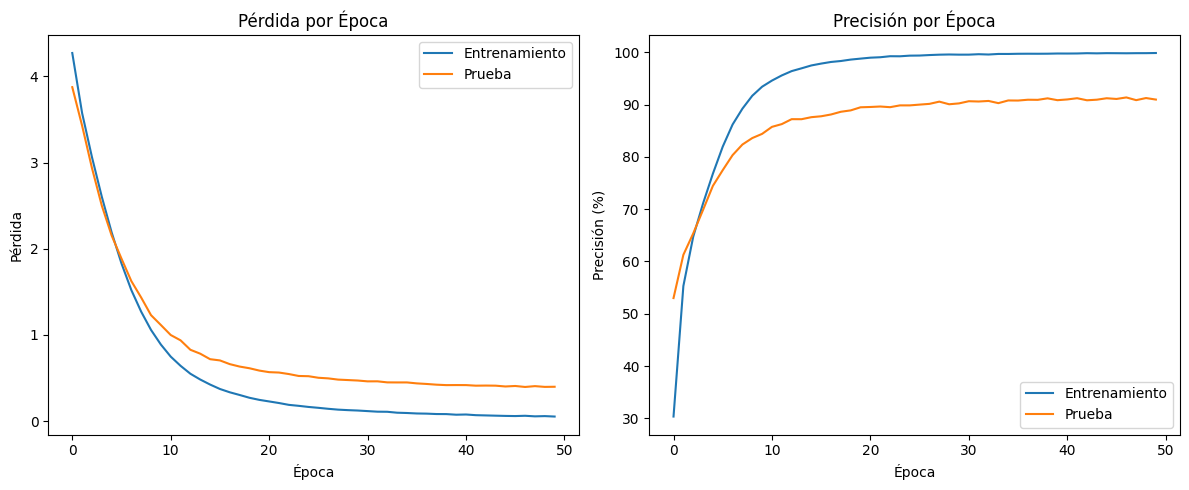

Modelo guardado como 'modelo_frutas_final.pth'


Prueba: 100%|██████████| 902/902 [00:36<00:00, 24.52it/s]



--- Resultado Final en Test ---
  Pérdida: 0.3998
  Precisión: 90.97%
porcentaje de error: 9.03%


In [48]:
    
perdidas_entrenamiento = []
precisiones_entrenamiento = []
perdidas_prueba = []
precisiones_prueba = []
epocas = 50  # Número de épocas
for epoca in range(epocas):
    torch.cuda.empty_cache()  # Limpia memoria antes de cada época
    print(f"VRAM usada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    #verificar_temperatura()  # Verificar temperatura antes de cada época
    print(f"\nÉpoca {epoca + 1}/{epocas}")
    
    # Entrenamiento
    perdida_ent, precision_ent, train_error = entrenar_epoca(
        model, train_loader, optimizer, criterion, device
    )
    
    perdidas_entrenamiento.append(perdida_ent)
    precisiones_entrenamiento.append(precision_ent)

    # 2. Evaluación en Test (opcional: cada X épocas para ahorrar tiempo)
    if (epoca + 1) % 1 == 0:  # Evalúa cada época
        perdida_test, precision_test, test_error = evaluar(
            model, test_loader, criterion, device
        )
        perdidas_prueba.append(perdida_test)
        precisiones_prueba.append(precision_test)

    # 3. Mostrar resumen
    print(f"\nResumen Época {epoca + 1}:")
    print(f"  Pérdida: Train = {perdida_ent:.4f} | Test = {perdida_test:.4f}")
    print(f"  Precisión: Train = {precision_ent:.2f}% | Test = {precision_test:.2f}%")
    print(f"  Error: entrenamiento: {train_error:.4f}% | error test: {test_error:.4f}%")
    print("-" * 50)

    # 4. Verificar condición de parada temprana
    #if precision_test >= 90 and test_error <= 5:
   #     print(f"✅ Criterios alcanzados: Precisión test {precision_test:.2f}% y error test {test_error:.2f}%")
  #      print("🛑 Deteniendo entrenamiento.")
 #       break  # Salir del bucle de entrenamiento
#scheduler.step(perdida_test)



graficar_resultados(
    perdidas_entrenamiento, precisiones_entrenamiento,
    perdidas_prueba, precisiones_prueba
)

torch.save(model.state_dict(), "modelo_frutas_final.pth")
print("Modelo guardado como 'modelo_frutas_final.pth'")

perdida_final, precision_final, error = evaluar(model, test_loader, criterion, device)
print(f"\n--- Resultado Final en Test ---")
print(f"  Pérdida: {perdida_final:.4f}")
print(f"  Precisión: {precision_final:.2f}%")
print(f"porcentaje de error: {error:.2f}%")

# Graficar resultados

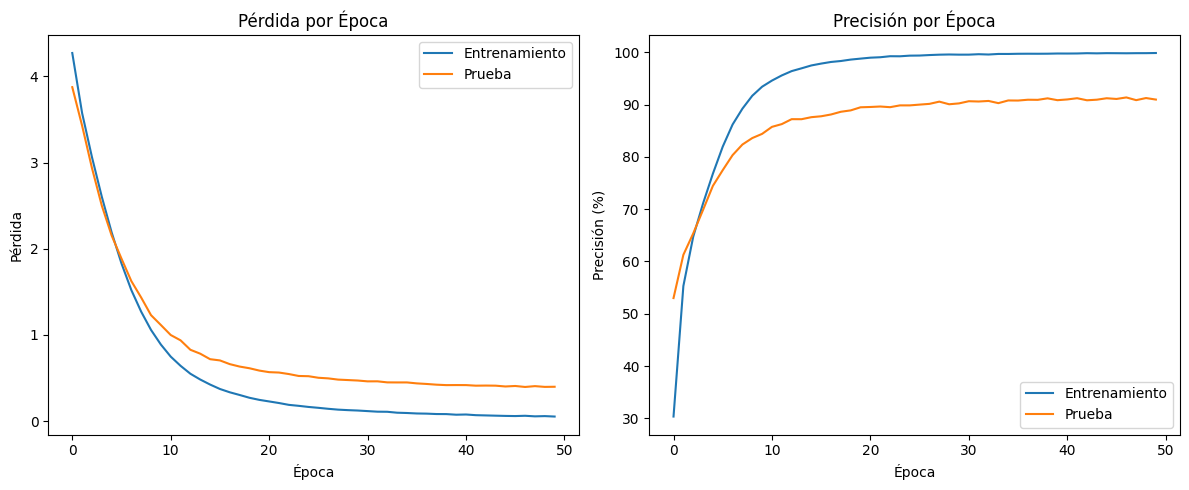

In [49]:
graficar_resultados(
    perdidas_entrenamiento, precisiones_entrenamiento,
    perdidas_prueba, precisiones_prueba
)

# Guardar modelo

In [50]:
torch.save(model.state_dict(), "modelo_frutas_final.pth")
print("Modelo guardado como 'modelo_frutas_final.pth'")

Modelo guardado como 'modelo_frutas_final.pth'


# Evaluación FINAL en Test

In [51]:
perdida_final, precision_final, error = evaluar(model, test_loader, criterion, device)
print(f"\n--- Resultado Final en Test ---")
print(f"  Pérdida: {perdida_final:.4f}")
print(f"  Precisión: {precision_final:.2f}%")
print(f"porcentaje de error: {error:.2f}%")

Prueba: 100%|██████████| 902/902 [00:37<00:00, 24.12it/s]


--- Resultado Final en Test ---
  Pérdida: 0.3998
  Precisión: 90.97%
porcentaje de error: 9.03%


In [52]:
# creamos las etiquetas
etiquetas = train_dataset.classes  # Etiquetas de las clases
print("Etiquetas:", etiquetas)

Etiquetas: ['Apple 10', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 19', 'Apple 6', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Cherry Wax not rippen 1', 'Chest

# cargar y probar el modelo con una imagen cualquiera
1️⃣ Cargar el modelo entrenado

In [53]:
# Cargar el modelo
modelo_cargado = FruitMLP() # Crear una nueva instancia del modelo
modelo_cargado.load_state_dict(torch.load("modelo_frutas_final.pth")) # Cargar los pesos
modelo_cargado.eval()  # Poner en modo evaluación

modelo_cargado.to(device)  # Mover el modelo al mismo dispositivo que la imagen


FruitMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30000, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=512, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=169, bias=True)
  )
)

2️⃣ Cargar una imagen de prueba
Usaremos PIL y torchvision para cargar y preprocesar la imagen.

In [54]:
from PIL import Image
import torchvision.transforms as transforms

# Transformaciones para la imagen (ajustar según tu modelo)
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Ajustar tamaño
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean= Media, std= Std)  # Normalizar
])

# Cargar imagen Apple hit 1
imagen = Image.open("C:/Users/OMEN/Downloads/26_100.jpg")  # Reemplaza con tu imagen
# imagen = Image.open("./Avocado 1.jpg")  # Reemplaza con tu imagen
imagen_mostrar = imagen
imagen = transformaciones(imagen)
imagen = imagen.unsqueeze(0)  # Agregar dimensión batch
imagen = imagen.to(device)  # Mover a GPU/CPU

3️⃣ Realizar la predicción

La imagen fue clasificada como la clase: Cherry 2


(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

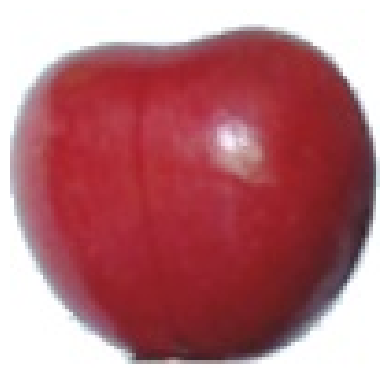

In [56]:
with torch.no_grad():  # Desactivar gradientes para inferencia
    salida = modelo_cargado(imagen)
    prediccion = torch.argmax(salida, dim=1).item()  # Obtener la clase con mayor probabilidad

print(f"La imagen fue clasificada como la clase: {etiquetas[prediccion]}")

# mostrar la imagen de estudio
plt.imshow(imagen_mostrar)
plt.axis('off')

La imagen fue clasificada como la clase: Cherry 2


(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

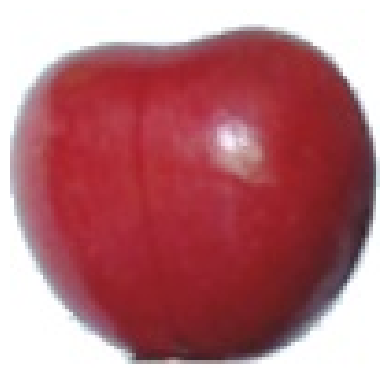

In [ ]:
with torch.no_grad():  # Desactivar gradientes para inferencia
    salida = modelo_cargado(imagen)
    prediccion = torch.argmax(salida, dim=1).item()  # Obtener la clase con mayor probabilidad

print(f"La imagen fue clasificada como la clase: {etiquetas[prediccion]}")

# mostrar la imagen de estudio
plt.imshow(imagen_mostrar)
plt.axis('off')